In [1]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
n = 1000
p = 10  # Dimensionality of Xi
m_values = [10, 100, 1000, 10000, 50000, 100000]

def rademacher_variable(size):
    return np.random.randint(0, 2, size) * 2 - 1

def generate_data():
    X = np.random.normal(0, 1, size=(n + m, p))
    eps = np.random.normal(0, 0.3, size=(n + m,))
    delta = rademacher_variable(n + m)
    Y = delta * np.sqrt(X[:, 0]**2 + X[:, 1]**2 + eps**2)
    return X, Y

# Estimate the true variance via Monte Carlo
X = np.random.normal(0, 1, size=(1000000, p))
eps = np.random.normal(0, 0.3, size=(1000000,))
delta = rademacher_variable(1000000)
Y = delta * np.sqrt(X[:, 0]**2 + X[:, 1]**2 + eps**2)
true = np.var(Y)


def fit_xgb_model(X, y):
    model = XGBRegressor()
    model.fit(X, y)
    return model

def fit_rf_model(X, y):
    model = RandomForestRegressor()
    model.fit(X, y)
    return model


def run_iteration(i, m):
    X, Y = generate_data()

    x_label, x_unlabel, y_label, _ = train_test_split(X, Y, train_size=n, random_state=i)

    x_label_1, x_label_2, y_label_1, y_label_2 = train_test_split(x_label, y_label, train_size=n//2, random_state=i)

    x_unlabel_1, x_unlabel_2 = train_test_split(x_unlabel, train_size=m//2, random_state=i)

    xgb_model1 = fit_xgb_model(x_label_1, y_label_1)
    xgb_model2 = fit_xgb_model(x_label_2, y_label_2)

    ghat1 = xgb_model2.predict(x_label_1)
    ghat2 = xgb_model1.predict(x_label_2)
    ghat3 = xgb_model2.predict(x_unlabel_1)
    ghat4 = xgb_model1.predict(x_unlabel_2)

    hhat1 = ghat1 - np.mean(np.concatenate((ghat1, ghat3)))
    hhat2 = ghat2 - np.mean(np.concatenate((ghat2, ghat4)))
    hhat3 = ghat3 - np.mean(np.concatenate((ghat1, ghat3)))
    hhat4 = ghat4 - np.mean(np.concatenate((ghat2, ghat4)))

    theta_1 = np.mean(y_label_1) - np.mean(ghat1) + np.mean(np.concatenate((ghat1, ghat3)))
    theta_2 = np.mean(y_label_2) - np.mean(ghat2) + np.mean(np.concatenate((ghat2, ghat4)))
    theta = 1/2 * theta_1 + 1/2 * theta_2

    sig2_epsilon = 1/n * (np.sum((y_label_1 - theta - hhat1)**2) + np.sum((y_label_2 - theta - hhat2)**2))
    b2 = 1/(n+m) * (np.sum(hhat1**2) + np.sum(hhat2**2) + np.sum(hhat3**2) + np.sum(hhat4**2)) + 2/n * (np.sum(hhat1 * (y_label_1 - theta - hhat1)) + np.sum(hhat2 * (y_label_2 - theta - hhat2)))

    ell1_1 = 1/2 * y_label_1**2 - y_label_1 * np.mean(y_label_1) + 1/2 * np.mean(y_label_1**2)
    ell1_2 = 1/2 * y_label_2**2 - y_label_2 * np.mean(y_label_2) + 1/2 * np.mean(y_label_2**2)
    ell1 = 1/2 * y_label**2 - y_label * np.mean(y_label) + 1/2 * np.mean(y_label**2)

    xgb_model1a = fit_xgb_model(x_label_1, ell1_1)
    xgb_model2a = fit_xgb_model(x_label_2, ell1_2)
    xgb_model_full = fit_xgb_model(x_label, ell1)

    fhat1 = xgb_model2a.predict(x_label_1)
    fhat2 = xgb_model1a.predict(x_label_2)
    fhat3 = xgb_model2a.predict(x_unlabel_1)
    fhat4 = xgb_model1a.predict(x_unlabel_2)
    fhat_label = xgb_model_full.predict(x_label)
    fhat_unlabel = xgb_model_full.predict(x_unlabel)

    U = np.var(y_label) - np.mean(np.concatenate([fhat1, fhat2])) + np.mean(np.concatenate([fhat1, fhat2, fhat3, fhat4]))
    Uplug = np.var(y_label) - np.mean(fhat_label) + np.mean(np.concatenate([fhat_label, fhat_unlabel]))

    sighat = sig2_epsilon + b2

    return sighat, np.var(y_label), U, Uplug

# Main loop
result1 = []
result2 = []
result3 = []

for m in tqdm(m_values):
    results = Parallel(n_jobs=-1)(delayed(run_iteration)(i, m) for i in range(5000))

    est1, est2, est3, est4 = zip(*results)

    MSE_ZB = np.mean((np.array(est1) - true)**2)
    MSE_U = np.mean((np.array(est2) - true)**2)
    MSE_cross = np.mean((np.array(est3) - true)**2)
    MSE_plug = np.mean((np.array(est4) - true)**2)

    result1.append(MSE_U / MSE_ZB)
    result2.append(MSE_U / MSE_cross)
    result3.append(MSE_U / MSE_plug)

 83%|████████████████████████████████████▋       | 5/6 [25:37<05:29, 329.53s/it]/Users/ilmun/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|████████████████████████████████████████████| 6/6 [34:32<00:00, 345.44s/it]


In [2]:
def run_iteration(i, m):
    X, Y = generate_data()

    x_label, x_unlabel, y_label, _ = train_test_split(X, Y, train_size=n, random_state=i)

    x_label_1, x_label_2, y_label_1, y_label_2 = train_test_split(x_label, y_label, train_size=n//2, random_state=i)

    x_unlabel_1, x_unlabel_2 = train_test_split(x_unlabel, train_size=m//2, random_state=i)

    rf_model1 = fit_rf_model(x_label_1, y_label_1)
    rf_model2 = fit_rf_model(x_label_2, y_label_2)

    ghat1 = rf_model2.predict(x_label_1)
    ghat2 = rf_model1.predict(x_label_2)
    ghat3 = rf_model2.predict(x_unlabel_1)
    ghat4 = rf_model1.predict(x_unlabel_2)

    hhat1 = ghat1 - np.mean(np.concatenate((ghat1, ghat3)))
    hhat2 = ghat2 - np.mean(np.concatenate((ghat2, ghat4)))
    hhat3 = ghat3 - np.mean(np.concatenate((ghat1, ghat3)))
    hhat4 = ghat4 - np.mean(np.concatenate((ghat2, ghat4)))

    theta_1 = np.mean(y_label_1) - np.mean(ghat1) + np.mean(np.concatenate((ghat1, ghat3)))
    theta_2 = np.mean(y_label_2) - np.mean(ghat2) + np.mean(np.concatenate((ghat2, ghat4)))
    theta = 1/2 * theta_1 + 1/2 * theta_2

    sig2_epsilon = 1/n * (np.sum((y_label_1 - theta - hhat1)**2) + np.sum((y_label_2 - theta - hhat2)**2))
    b2 = 1/(n+m) * (np.sum(hhat1**2) + np.sum(hhat2**2) + np.sum(hhat3**2) + np.sum(hhat4**2)) + 2/n * (np.sum(hhat1 * (y_label_1 - theta - hhat1)) + np.sum(hhat2 * (y_label_2 - theta - hhat2)))

    ell1_1 = 1/2 * y_label_1**2 - y_label_1 * np.mean(y_label_1) + 1/2 * np.mean(y_label_1**2)
    ell1_2 = 1/2 * y_label_2**2 - y_label_2 * np.mean(y_label_2) + 1/2 * np.mean(y_label_2**2)
    ell1 = 1/2 * y_label**2 - y_label * np.mean(y_label) + 1/2 * np.mean(y_label**2)

    rf_model1a = fit_rf_model(x_label_1, ell1_1)
    rf_model2a = fit_rf_model(x_label_2, ell1_2)
    rf_model_full = fit_rf_model(x_label, ell1)

    fhat1 = rf_model2a.predict(x_label_1)
    fhat2 = rf_model1a.predict(x_label_2)
    fhat3 = rf_model2a.predict(x_unlabel_1)
    fhat4 = rf_model1a.predict(x_unlabel_2)
    fhat_label = rf_model_full.predict(x_label)
    fhat_unlabel = rf_model_full.predict(x_unlabel)

    U = np.var(y_label) - np.mean(np.concatenate([fhat1, fhat2])) + np.mean(np.concatenate([fhat1, fhat2, fhat3, fhat4]))
    Uplug = np.var(y_label) - np.mean(fhat_label) + np.mean(np.concatenate([fhat_label, fhat_unlabel]))

    sighat = sig2_epsilon + b2

    return sighat, np.var(y_label), U, Uplug

# Main loop
result4 = []
result5 = []
result6 = []


for m in tqdm(m_values):
    results = Parallel(n_jobs=-1)(delayed(run_iteration)(i, m) for i in range(5000))

    est1, est2, est3, est4 = zip(*results)

    MSE_ZB = np.mean((np.array(est1) - true)**2)
    MSE_U = np.mean((np.array(est2) - true)**2)
    MSE_cross = np.mean((np.array(est3) - true)**2)
    MSE_plug = np.mean((np.array(est4) - true)**2)

    result4.append(MSE_U / MSE_ZB)
    result5.append(MSE_U / MSE_cross)
    result6.append(MSE_U / MSE_plug)

100%|█████████████████████████████████████████| 6/6 [2:20:39<00:00, 1406.63s/it]


In [3]:
from matplotlib.ticker import FuncFormatter

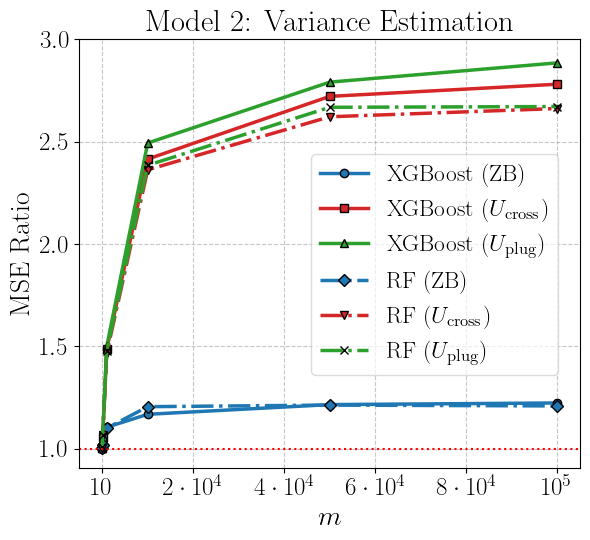

In [5]:
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Function to format x-axis labels using power notation (e.g., 10^3)
def format_power_notation(value, tick_number):
    if value >= 1000:
        power = int(np.log10(value))
        coeff = value / 10**power
        if coeff == 1:
            return f'$10^{power}$'
        else:
            return f'${coeff:.0f} \\cdot 10^{power}$'
    else:
        return int(value)
    
# Create the figure with a specific aspect ratio
plt.figure(figsize=(6, 5.5))  # Adjust figure size as needed

# Use consistent line styles and colors with markers
plt.plot(m_values, result1, label='XGBoost (ZB)', linewidth=2.5, linestyle='-', color=custom_palette[0], marker='o', markeredgecolor='black')
plt.plot(m_values, result2, label='XGBoost ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='-', color=custom_palette[3], marker='s', markeredgecolor='black')
plt.plot(m_values, result3, label='XGBoost ($U_{\\mathrm{plug}}$)', linewidth=2.5, linestyle='-', color=custom_palette[2], marker='^', markeredgecolor='black')
plt.plot(m_values, result4, label='RF (ZB)', linewidth=2.5, linestyle='-.', color=custom_palette[0], marker='D', markeredgecolor='black')
plt.plot(m_values, result5, label='RF ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='-.', color=custom_palette[3], marker='v', markeredgecolor='black')
plt.plot(m_values, result6, label='RF ($U_{\\mathrm{plug}}$)', linewidth=2.5, linestyle='-.', color=custom_palette[2], marker='x', markeredgecolor='black')

plt.xlabel('$m$', fontsize=20)
plt.ylabel('MSE Ratio', fontsize=20)
plt.title('Model 2: Variance Estimation', fontsize=22)  # Add a title

# Adjust the legend
#legend = plt.legend(fontsize=17, loc='upper right', bbox_to_anchor=(0.5, -0.15))  # Add a title and adjust location
legend = plt.legend(fontsize=17, loc='upper right', bbox_to_anchor=(0.98, 0.76))
legend.get_title().set_fontsize(20)  # Increase the title fontsize
legend.get_frame().set_alpha(0.7)  # Make the legend background transparent
legend.get_frame().set_facecolor('white')  # Set a white background

# Set y-axis ticks starting at y=1 with appropriate increments
plt.axhline(y=1, color='red', linestyle=':', label='Baseline at y=1')
plt.yticks([1.0,1.5,2.0,2.5,3.0],fontsize=18)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_power_notation))
plt.xticks([10, 20000, 40000, 60000, 80000, 100000], fontsize=18)

# Use a professional LaTeX font style
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model2_variance.pdf', format='pdf', dpi=300)

plt.show()